In [1]:
import os
import re
import sys
import glob
import shutil
import numpy as np
import pandas as pd
from scipy import sparse, io
import matplotlib
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scrublet as scr

In [2]:
matplotlib.rcParams.update({'font.size': 12})
# %config InlineBackend.figure_format = 'retina'
sc.settings.set_figure_params(dpi=80)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
# https://eleozzr.github.io/desc/tutorial.html

## Data preparation

In [ ]:
# cmd params
arg_keys = {
    'work_dir': "--work_dir=",
}
args = dict()
for argv in sys.argv[1:]:
    for k, arg_key in arg_keys.items():
        if argv.find(arg_key) == 0:
            args[k] = argv[len(arg_key):]

In [3]:
# ### /** Windows operation system **/
# work_dir = 'D:/Document/Programming/Python/deepbio/symphony/github/scanalysis/scqqapy/data/h5/sarcoma/'
# args = dict()
# args['work_dir'] = work_dir
# args['data_work_dir'] = work_dir
# args['fig_work_dir'] = work_dir


# ### /** Linux operation system **/
args['data_work_dir'] = args['work_dir'] + 'scanpy_integ_4_doublet.dir/'
args['fig_work_dir'] = args['work_dir'] + 'scanpy_integ_4_doublet_fig.dir/'

In [4]:
# read
adata = sc.read_h5ad(args['work_dir'] + 'scanpy_integ_3_filter.dir/adata_filt.h5ad')
print(adata.obs['sample'].value_counts())

119289-CCS-08-snRNAseq_S2    6717
119290-CCS-15-snRNAseq_S3    2029
119291-CCS-72-snRNAseq_S4    2021
119288-CCS-07-snRNAseq_S1    1251
Name: sample, dtype: int64


## Doublet

In [5]:
def console(adata):
    print('remaining cells: {}, remaining genes: {}'.format(adata.X.shape[0], adata.X.shape[1]))
    
def saveTo(old_fn='scatter', new_fn='stat_basic', kind='.pdf'):
    os.replace(os.path.join(os.getcwd(), 'figures/' + old_fn + kind), os.path.join(os.getcwd(), 'figures/' + new_fn + kind))
    shutil.move(os.path.join(os.getcwd(), 'figures/' + new_fn + kind), args['fig_work_dir'] + new_fn + kind)
    shutil.rmtree(os.path.join(os.getcwd(), 'figures'))

In [6]:
adata_cp = adata.copy()
adata_cp

AnnData object with n_obs × n_vars = 12018 × 34540
    obs: 'type', 'sample', 'batch', 'n_counts', 'pct_ribo', 'pct_hb', 'pct_mito', 'pct_chrY', 'cnt_XIST', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'gene_name', 'n_cells'
    uns: 'sample_colors'

In [7]:
# normalize
# adata.raw = None
# adata.raw = adata
sc.pp.normalize_per_cell(adata_cp, counts_per_cell_after=1e4)
sc.pp.log1p(adata_cp)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [8]:
sc.pp.scale(adata_cp, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [9]:
scrub = scr.Scrublet(adata_cp.X)
adata_cp.obs['doublet_scores'], adata_cp.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...


D:\Programming\anaconda3\envs\scanal\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 42.0 seconds


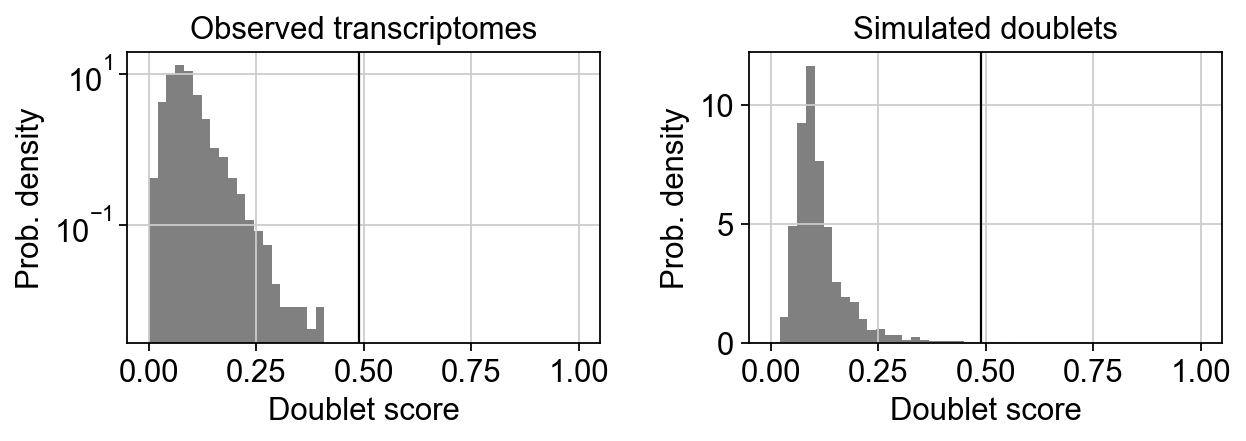

In [10]:
fig, axs = scrub.plot_histogram()
fig.savefig(args['fig_work_dir'] + 'doublet_hist.pdf', bbox_inches="tight", dpi=300)

In [11]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))

D:\Programming\anaconda3\envs\scanal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


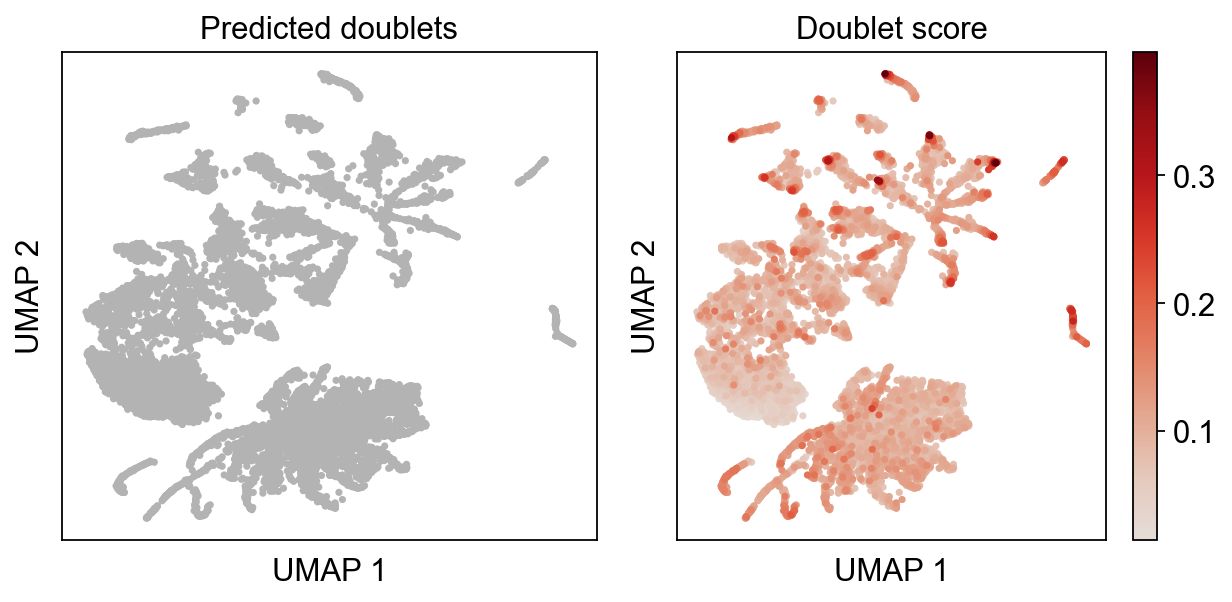

In [12]:
fig, axs = scrub.plot_embedding('UMAP', order_points=True)
fig.savefig(args['fig_work_dir'] + 'doublet_umap_scr.pdf', bbox_inches="tight", dpi=300)

In [13]:
adata_cp.obs['predicted_doublets'].sum()

0

In [14]:
adata_cp.obs['doublet_info'] = adata_cp.obs["predicted_doublets"].astype(str)
adata_cp.obs

,type,sample,batch,n_counts,pct_ribo,pct_hb,pct_mito,pct_chrY,cnt_XIST,n_genes,S_score,G2M_score,phase,doublet_scores,predicted_doublets,doublet_info
barcode,,,,,,,,,,,,,,,,
AAACCCAAGGTAAGGA-0,0,119291-CCS-72-snRNAseq_S4,0,3616.0,0.060011,0.000000,0.0,0.000830,0.0,2089,0.222478,0.043860,S,0.109420,False,False
AAACCCAAGTATTAGG-0,0,119291-CCS-72-snRNAseq_S4,0,1234.0,0.054295,0.000000,0.0,0.000810,0.0,936,-0.148322,-0.191702,G1,0.084006,False,False
AAACCCACAACCGGAA-0,0,119291-CCS-72-snRNAseq_S4,0,859.0,0.129220,0.000000,0.0,0.000000,0.0,625,0.125963,1.876304,G2M,0.053232,False,False
AAACCCAGTTGATGTC-0,0,119291-CCS-72-snRNAseq_S4,0,3708.0,0.081176,0.000000,0.0,0.001348,0.0,2283,1.239625,0.565093,S,0.068296,False,False
AAACCCATCCAAACCA-0,0,119291-CCS-72-snRNAseq_S4,0,2701.0,0.053684,0.000000,0.0,0.001111,0.0,1852,-0.022868,-0.036448,G1,0.106742,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTTGTTGG-3,3,119288-CCS-07-snRNAseq_S1,3,1473.0,0.051595,0.000000,0.0,0.001358,0.0,1047,0.049998,0.024766,S,0.073134,False,False
TTTGTTGAGCAGTAAT-3,3,119288-CCS-07-snRNAseq_S1,3,1129.0,0.052259,0.000000,0.0,0.003543,0.0,835,0.350033,-0.170067,S,0.053232,False,False
TTTGTTGCAAACTAAG-3,3,119288-CCS-07-snRNAseq_S1,3,3970.0,0.096222,0.000756,0.0,0.001259,0.0,1959,0.020219,-0.059296,S,0.084006,False,False


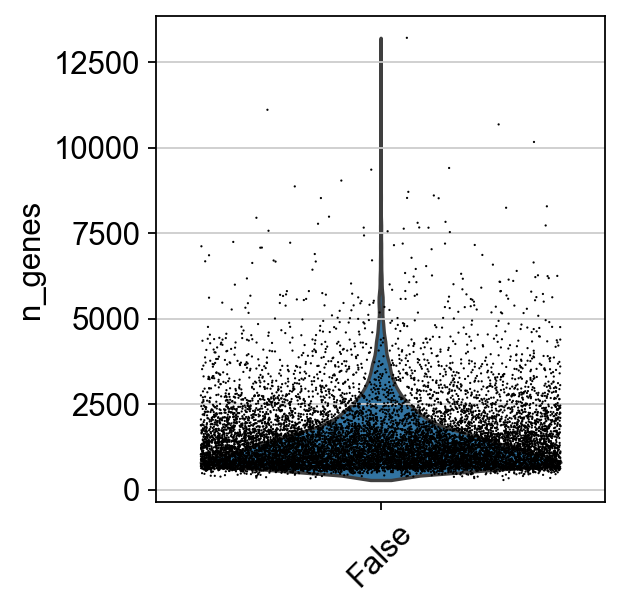

In [15]:
sc.pl.violin(adata_cp, 'n_genes', jitter=0.4, groupby = 'doublet_info', rotation=45, save='.pdf')
saveTo(old_fn='violin', new_fn='num_gene_doublet', kind='.pdf')

In [16]:
sc.pp.highly_variable_genes(adata_cp, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_cp = adata_cp[:, adata_cp.var.highly_variable]
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.tl.pca(adata_cp, svd_solver='arpack')
sc.pp.neighbors(adata_cp, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_cp)

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


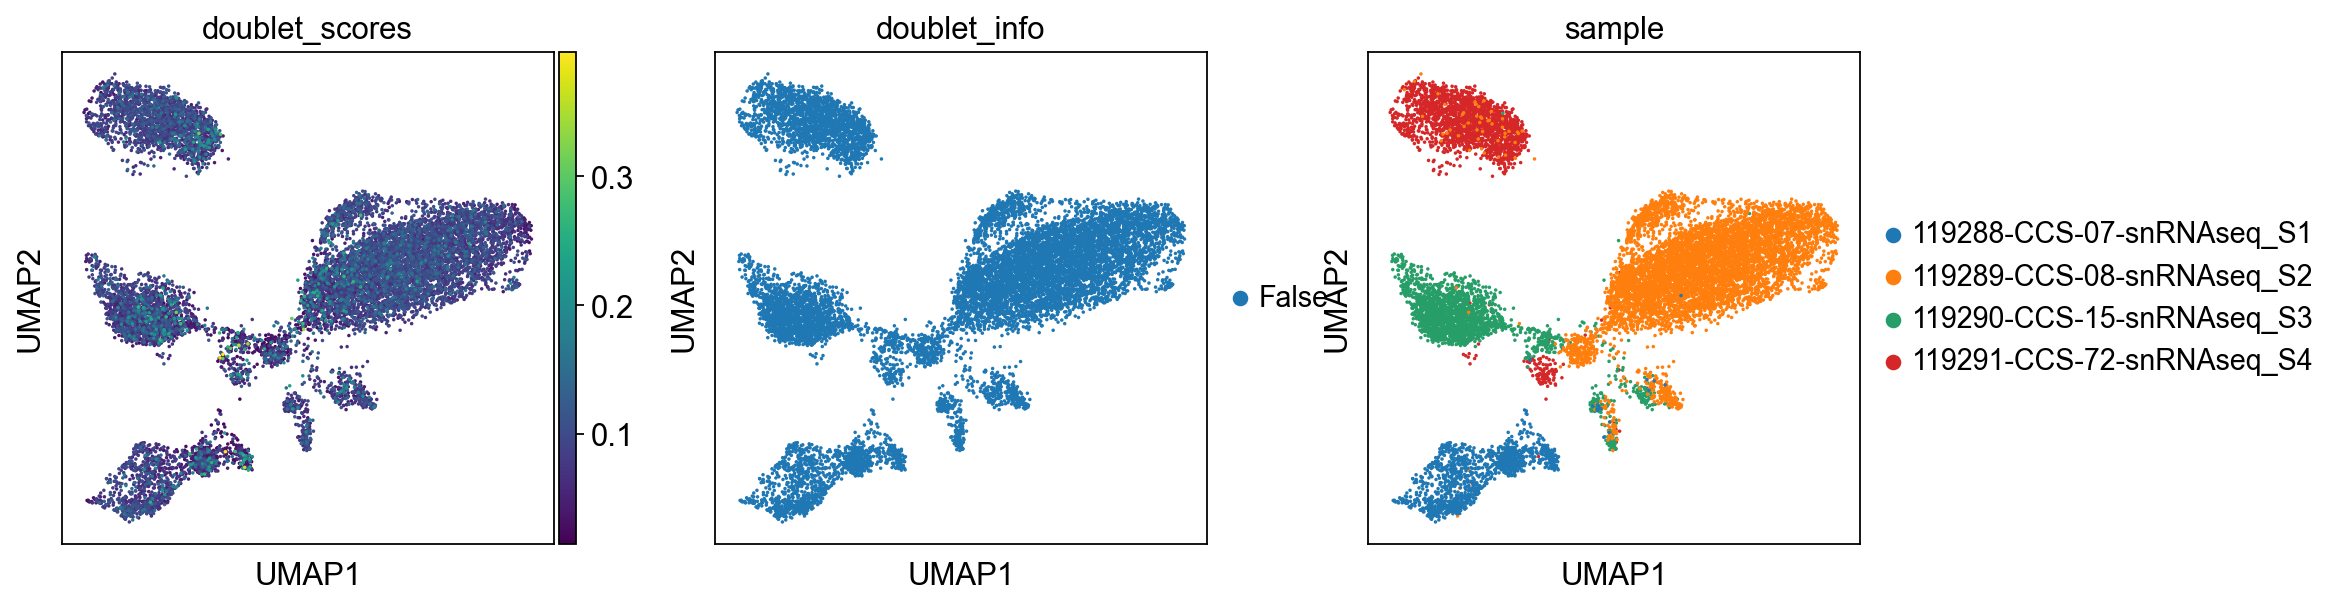

In [20]:
sc.pl.umap(adata_cp, color=['doublet_scores', 'doublet_info', 'sample'], save='.pdf')
saveTo(old_fn='umap', new_fn='doublet_umap_scanpy', kind='.pdf')

In [23]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'], adata.obs['doublet_info'] = adata_cp.obs['doublet_scores'], adata_cp.obs['predicted_doublets'], adata_cp.obs['doublet_info']
adata.uns['doublet_info_colors'] = adata_cp.uns['doublet_info_colors']

In [25]:
adata = adata[adata.obs['doublet_info'] == 'False', :]

In [ ]:
del(adata_cp)

In [26]:
adata.write(args['data_work_dir'] + 'adata_rv_dblt.h5ad')